In [3]:
import sys

import os
import glob

import pickle
import gzip
import shutil

import h5py

import numpy as np

from scipy.stats import norm
from scipy.integrate import simpson
from scipy.interpolate import interp1d

from astropy.io import fits
from astropy.table import Table

import astropy.units as u
from astropy.constants import c
from astropy.cosmology import LambdaCDM

import corner
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText

sys.path.append(os.path.abspath('..'))

from mrileyowens.beagle import ew, m_uv
from mrileyowens.stats import weighted_quantile

/Users/a15136/Documents/research/mrileyowens/beagle.py:34: SyntaxWarning: invalid escape sequence '\s'
  'sigma' : ['GALAXY PROPERTIES', '\sigma', 1, 'km s$^{-1}$'],
/Users/a15136/Documents/research/mrileyowens/beagle.py:35: SyntaxWarning: invalid escape sequence '\o'
  'M_tot' : ['GALAXY PROPERTIES', r'M_{{\rm tot}}', 1e6, 'MM$_\odot$'],
/Users/a15136/Documents/research/mrileyowens/beagle.py:36: SyntaxWarning: invalid escape sequence '\o'
  'M_star' : ['GALAXY PROPERTIES', r'M_{{\rm star}}', 1e6, 'MM$_\odot$'],
/Users/a15136/Documents/research/mrileyowens/beagle.py:37: SyntaxWarning: invalid escape sequence '\o'
  'M_liv' : ['GALAXY PROPERTIES', r'M_{{\rm liv}}', 1e6, 'MM$_\odot$'],
/Users/a15136/Documents/research/mrileyowens/beagle.py:38: SyntaxWarning: invalid escape sequence '\_'
  'M_remnants' : ['GALAXY PROPERTIES', r'M_{{\rm remnants}}', 1e6, 'MM$\_odot$'],
/Users/a15136/Documents/research/mrileyowens/beagle.py:50: SyntaxWarning: invalid escape sequence '\o'
  'SFR' : ['STAR FO

In [ ]:
def calculate_m_uv():

    '''
    Calculate the absolute UV magnitudes of the CSFH BEAGLE fits
    '''

    # Set common directories
    home = os.getcwd()
    results = f'{home}/results'

    #files_priors = glob.glob(f'{results}/beagle_fits/endsley2024_f775w_dropouts_beagle_csfh_fits_ew_priors/*_GOODS*_BEAGLE.fits.gz')

    # Get the CSFH BEAGLE fits to the F775W dropouts
    files = glob.glob(f'{results}/beagle_fits/endsley2024_f775w_dropouts_beagle_csfh_fits/*_GOODS*_BEAGLE.fits.gz')

    # Calculate and write the absolute UV magnitudes of the dropout galaxies
    m_uv(files, f'{results}/m_uv/endsley2024_f775w_dropouts_beagle_csfh_fits_m_uv.h5')

def calculate_ew():

    # Set common directories
    home = os.getcwd()
    results = f'{home}/results'

    # Open the absolute UV magnitude measurents of the BEAGLE model SEDs
    m_uvs = h5py.File(f'{results}/m_uv/endsley2024_f775w_dropouts_beagle_csfh_fits_m_uv.h5')

    '''
    def BEAGLE_median(prob, param):

        s = np.argsort(param)
        cdf = np.cumsum(prob[s])
        cdf /= np.max(cdf)

        interp_param = interp1d(cdf, param[s])
        median = interp_param(0.5)
        interval = interp_param([0.16,0.84])

        return median
    '''

    # Create empty lists for the three subsamples (absolute UV magnitude bins)
    ids_bright, ids_faint, ids_vfaint = [], [], []
    #faint = []
    #vfaint = []

    # For each object ID
    for key in list(m_uvs.keys()):

        # Get the object's associated group in the absolute UV magnitude measurements
        group = m_uvs[key]

        # Get the object's absolute UV magnitude measurements and associated probabilities
        params = group['m_uv'][:]
        probabilities = group['probabilities'][:]

        # Calculate the weighted median absolute UV magnitude
        median = weighted_quantile(params, probabilities, 0.5)

        # Append the object's ID to the appropriate absolute UV magnitude bin
        if median < -19.5:
            ids_bright.append(key)
        elif median > -19.5 and median < -18:
            ids_faint.append(key)
        elif median > -18:
            ids_vfaint.append(key)

    # Set string identifiers for the different absolute UV magnitude bins
    names = ['bright', 'faint', 'vfaint']

    # For each set of IDs in the absolute UV magnitude bins
    for i, ids in enumerate([ids_bright, ids_faint, ids_vfaint]):

        # Get the associated BEAGLE fits of the IDs, for both the complete and partial fits (the latter to sample the EW priors)
        files = [f'{results}/beagle_fits/endsley2024_f775w_dropouts_beagle_csfh_fits/{id}_BEAGLE.fits.gz' for id in ids]
        files_priors = [f'{results}/beagle_fits/endsley2024_f775w_dropouts_beagle_csfh_fits_ew_priors/{id}_BEAGLE.fits.gz' for id in ids]

        # Measure the [O III] and H-beta EWs of the corresponding BEAGLE fits
        ew(files, f'{results}/ew/endsley2024_f775w_dropouts_beagle_csfh_fits_ews_{names[i]}.h5')
        ew(files_priors, f'{results}/ew/endsley2024_f775w_dropouts_beagle_csfh_fits_ews_{names[i]}_priors.h5')#, redshifts=zs)

        #zs = h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_{names[i]}.h5', 'r')

        #ew(files_priors, f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_priors_{names[i]}.h5')#, redshifts=zs)

def calculate_ew_distribution():

    def p_gaussian(bins, mean, variance):

        bins_model = np.arange(np.min(bins), np.max(bins) + 0.05, (bins[1] - bins[0]) / 100)

        model = np.exp(-(bins_model - mean)**2 / (2 * variance))

        p_gaussian = np.zeros(len(bins[:-1]))

        for i, bin in enumerate(bins[:-1]):

            p_gaussian[i] = np.sum(model[(bins_model >= bin) & (bins_model < bins[i + 1])])# * (bins[i + 1] - bin)

        p_gaussian = p_gaussian / (np.sum(p_gaussian) * (bins[1] - bins[0]))

        p_gaussian = norm.cdf(bins[1:], mean, np.sqrt(variance)) - norm.cdf(bins[:-1], mean, np.sqrt(variance))

        return p_gaussian

    # Set common directories
    home = os.getcwd()
    results = f'{home}/results'

    bins = np.arange(2.5, 3.7, 0.05) 
    bins = np.insert(bins, 0, 0)
    bins = np.append(bins, 4)
    print(bins)

    # From Ryan's paper: EW values from 10^2.5 - 10^3.7, in bins of 0.05 dex

    names = ['bright', 'faint', 'vfaint']

    for name in names:

        with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_{name}.h5', 'r') as f:

            print(len(f.keys()))

    for name in names:

        with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_priors_{name}.h5', 'r') as f_prior:

            # Get the EW prior distributions
            ews = f_prior

            with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_{name}.h5', 'r') as f:

                # Make empty lists for the probabilities, means, and variances
                probabilities = []
                means = []
                variances = []

                # For each sample
                for n in range(10000):

                    # Randomly draw, from a uniform distribution, a mean and variance of an assumed distribution
                    mean = np.random.uniform(0, 4)
                    variance = np.random.uniform(0.01, 2)

                    means.append(mean)
                    variances.append(variance)

                    # From the sampled mean and variance, create a model Gaussian distribution
                    p_model = p_gaussian(bins, mean, variance)

                    sums = []

                    # For each object
                    for key in list(f.keys()):

                        #mask = catalog['ID'] == key

                        # Get the prior distributions of the EWs
                        oiii_ews_prior = ews[key]['oiii_ews'][:]
                        hb_ews_prior = ews[key]['hb_ews'][:]

                        # Get the posterior distributions of the EWs
                        oiii_ews_posterior = f[key]['oiii_ews'][:]
                        hb_ews_posterior = f[key]['hb_ews'][:]

                        # Add the EWs together to get the [O III] + H-beta EW distributions
                        ew_prior = oiii_ews_prior + hb_ews_prior
                        ew_posterior = oiii_ews_posterior + hb_ews_posterior

                        #print(np.median(ew_prior), np.median(ew_posterior))

                        # Create a normalized histogram of the logarithmic EW distributions
                        hist_prior, hist_prior_bins = np.histogram(np.log10(ew_prior), bins=bins, density=True)
                        hist_prior = hist_prior / np.sum(hist_prior)

                        hist_posterior, hist_posterior_bins = np.histogram(np.log10(ew_posterior), bins=bins, density=True)
                        hist_posterior = hist_posterior / np.sum(hist_posterior)

                        '''
                        fig, ax = plt.subplots()

                        print(hist_prior)
                        print(hist_posterior)

                        centers = (bins[:-1] + bins[1:]) / 2

                        #ax.plot(centers, hist_prior, color='black', ds='steps-mid')
                        #ax.plot(centers, hist_posterior, color='red', ds='steps-mid')

                        ax.hist(np.log10(ew_prior), bins, color='black', density=True, alpha=0.5)
                        ax.hist(np.log10(ew_posterior), bins, color='red', density=True, alpha=0.5)

                        plt.show()

                        #print(hist_prior, hist_posterior)
                        '''

                        #p = hist_posterior / (1 / len(hist_prior_bins)) #hist_prior
                        p = hist_posterior / (hist_prior + 1e-10)

                        #print(p)

                        #mask = np.isnan(p) | np.isinf(p) #| (p == 0)

                        p = np.where(np.isnan(p) | np.isinf(p), 1e-10, p)

                        #p = p[~mask]#[~mask]#np.where(np.isnan(p), 0, p)
                        #p = p[~m.isinf(p)]#np.where(np.isinf(p), 0, p)

                        #p_model_n = p_model[~mask]#[~mask]
                        p_model_n = p_model

                        #p = p / np.sum(p)

                        #p = np.where(np.isnan(p), 0, p)

                        sum = 0

                        for j, _ in enumerate(p):

                            sum += p[j] * p_model_n[j]

                        sums.append(sum)

                    sums = np.array(sums)
                    #print(sums)

                    sums = sums[~(np.isnan(sums) | (sums == 0))]

                    #print(sums)
                    product_log = np.sum(np.log(sums))
                    product = np.prod(sums)
                    #print(product)

                    #print(np.mean(sums))

                    #product = 10**(np.sum(np.log10(sums)))

                    #print()

                    #print(product)

                    probabilities.append(product_log)

                with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/ew_distribution_posteriors_{name}.h5', 'a') as f_posteriors:

                    '''
                    if ids[i] in list(f.keys()):
                        group = f[ids[i]]
                        if 'oiii_ews' in group:
                            del group['oiii_ews']
                        if 'hb_ews' in group:
                            del group['hb_ews']
                        #if 'l_uvs' in group:
                        #    del group['l_uvs']
                        #if 'f200w' in group:
                        #    del group['f200w']
                        #if 'f200w_err' in group:
                        #    del group['f200w_err']
                        if 'probabilities' in group:
                            del group['probabilities']
                        if 'z_phot' in group:
                            del group['z_phot']
                    else:
                        group = f.create_group(ids[i])
                    '''

                    if 'posteriors' in list(f_posteriors.keys()):
                        group = f_posteriors['posteriors']

                        if 'means' in group:
                            del group['means']
                        if 'variances' in group:
                            del group['variances']
                        if 'probabilities' in group:
                            del group['probabilities']

                    else:
                        group = f_posteriors.create_group('posteriors')

                    #f200w_idx = [k for k, file in enumerate(fit.galaxy.filter_set.filt_dict.keys()) if 'NRC_F200W' in file]
                    #print(f200w_idx)
                    #print(list(fit.galaxy.filter_set.filt_dict.keys()))#[f200w_idx])


                    group.create_dataset('means', data=np.array(means, dtype=np.float64))
                    group.create_dataset('variances', data=np.array(variances, dtype=np.float64))
                    group.create_dataset('probabilities', data=np.array(probabilities, dtype=np.float64))

                    #group = f.create_group(ids[i])
                    #dataset = group.create_dataset('hb_ews', data=np.array(hb_ews, dtype=np.float64))
                    #dataset = group.create_dataset('oiii_ews', data=np.array(oiii_ews, dtype=np.float64))
                    #dataset = group.create_dataset('l_uvs', data=np.array(l_uvs, dtype=np.float64))
                    #dataset = group.create_dataset('f200w', data=np.array(galaxy.photometry[:,1][f200w_idx]))#photometry_med.to(u.uJy, u.spectral_density(w_effs)).value[fit.galaxy.filter_set.filt_names.index('NIRCam.F200W')], dtype=np.float64))
                    #dataset = group.create_dataset('f200w_err', data=np.array(galaxy.photometry[:,2][f200w_idx]))#(photometry_ul - photometry_ll).to(u.uJy, u.spectral_density(w_effs)).value[fit.galaxy.filter_set.filt_names.index('NIRCam.F200W')], dtype=np.float64))
                    #print(z)
                    #dataset = group.create_dataset('probabilities', data=np.array(prob, dtype=np.float64))
                    #dataset = group.create_dataset('z_phot', data=np.array(z, dtype=np.float64))
                    #group.attrs['name'] = ids[i]

                    #print(group['means'][:])
                    #print(group['variances'][:])
                    #print(group['probabilities'][:])
                    #print(f_posteriors)

                f_posteriors.close()

                f.close()

            #print(ews)

        results = f'{os.getcwd()}/results'
        with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/ew_distribution_posteriors_{name}.h5', 'a') as f:

            means = 10**f['posteriors']['means'][:]# + np.log10(7)
            variances = np.sqrt(f['posteriors']['variances'][:])
            probabilities = f['posteriors']['probabilities'][:]

            probabilities = np.exp(probabilities - np.max(probabilities))

            #probabilites = probabilities / np.sum(probabilities)

            samples = np.vstack([means,variances]).T
            print(len(probabilities))
            print(len(probabilities[np.isnan(probabilities)]))
            print(samples)
            print(probabilities)
            corner.corner(samples, weights=probabilities, labels=['Mean', 'Standard deviation'], show_titles=True)

            #corner.corner.savefig(f'{results}/oiii_ew_distribution_log_normal_fit_posteriors.pdf')

In [ ]:
calculate_m_uv()

In [7]:
calculate_ew()

In [4]:
m_uvs = h5py.File('./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_m_uv.h5')

def BEAGLE_median(prob, param):

    s = np.argsort(param)
    cdf = np.cumsum(prob[s])
    cdf /= np.max(cdf)

    interp_param = interp1d(cdf, param[s])
    median = interp_param(0.5)
    interval = interp_param([0.16,0.84])

    return median

bright = []
faint = []
vfaint = []

for key in list(m_uvs.keys()):

    group = m_uvs[key]

    params = group['m_uv'][:]
    probabilities = group['probabilities'][:]

    median = BEAGLE_median(probabilities, params)

    if median < -19.5:
        bright.append(key)
    elif median > -19.5 and median < -18:
        faint.append(key)
    elif median > -18:
        vfaint.append(key)

names = ['bright', 'faint', 'vfaint']

for i, ids in enumerate([bright, faint, vfaint]):

    print(names[i])
    files = [f'./full_w335m_mup300/{id}_BEAGLE.fits.gz' for id in ids]
    files_priors = [f'./endsley2024_f775w_dropouts_csfh_ew_priors/{id}_BEAGLE.fits.gz' for id in ids]

    ew(files, f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_{names[i]}.h5')

    #zs = h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_{names[i]}.h5', 'r')

    ew(files_priors, f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_priors_{names[i]}.h5')#, redshifts=zs)

'''
ew(files, './results/endsley2024_f775w_dropouts_beagle_csfh_ews/endsley2024_f775w_dropouts_beagle_csfh_ews.h5')

zs = h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/endsley2024_f775w_dropouts_beagle_csfh_ews.h5', 'r')

ew(files_priors, './results/endsley2024_f775w_dropouts_beagle_csfh_ews/endsley2024_f775w_dropouts_beagle_csfh_ews_priors.h5', redshifts=zs)

#files = glob.glob('./full/*_GOODS*_BEAGLE.fits.gz')
#ew(files, './results/endsley2024_f775w_dropouts_beagle_csfh_ews/endsley2024_f775w_dropouts_beagle_csfh_ews.h5')
'''

bright
faint
vfaint


"\new(files, './results/endsley2024_f775w_dropouts_beagle_csfh_ews/endsley2024_f775w_dropouts_beagle_csfh_ews.h5')\n\nzs = h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/endsley2024_f775w_dropouts_beagle_csfh_ews.h5', 'r')\n\new(files_priors, './results/endsley2024_f775w_dropouts_beagle_csfh_ews/endsley2024_f775w_dropouts_beagle_csfh_ews_priors.h5', redshifts=zs)\n\n#files = glob.glob('./full/*_GOODS*_BEAGLE.fits.gz')\n#ew(files, './results/endsley2024_f775w_dropouts_beagle_csfh_ews/endsley2024_f775w_dropouts_beagle_csfh_ews.h5')\n"

[0.   2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.   3.05 3.1
 3.15 3.2  3.25 3.3  3.35 3.4  3.45 3.5  3.55 3.6  3.65 3.7  4.  ]
53
135
82


10000
0
[[2.40545702e+02 3.82951252e-01]
 [7.68131247e+03 5.25334087e-01]
 [5.12520838e+03 9.54091562e-01]
 ...
 [4.83503148e+01 1.04628630e+00]
 [1.46006861e+01 9.11979264e-01]
 [1.99729886e+00 1.04643363e+00]]
[5.95543356e-30 1.99782492e-38 4.30070709e-23 ... 5.48957657e-33
 8.54540964e-56 4.98512016e-85]


10000
0
[[3.35518307e+01 1.10092701e+00]
 [6.69831768e+03 8.36415963e-01]
 [1.18846723e+01 9.29044418e-01]
 ...
 [4.76493048e+02 1.39392709e+00]
 [8.58362059e+03 1.58256516e-01]
 [6.56991127e+03 1.06285802e+00]]
[1.51039316e-51 2.59749658e-65 1.15133770e-83 ... 3.87861456e-39
 0.00000000e+00 3.01550260e-60]


10000
0
[[8.74167178e+01 1.26135006e+00]
 [4.38382673e+02 9.49192033e-01]
 [1.36529259e+00 1.21698868e+00]
 ...
 [4.85563923e+02 1.26298884e+00]
 [1.30473657e+01 6.55606788e-01]
 [1.37670088e+03 1.32114017e+00]]
[2.93094062e-13 1.62388911e-07 7.68539456e-53 ... 2.68674789e-12
 3.40481777e-51 6.00018311e-17]


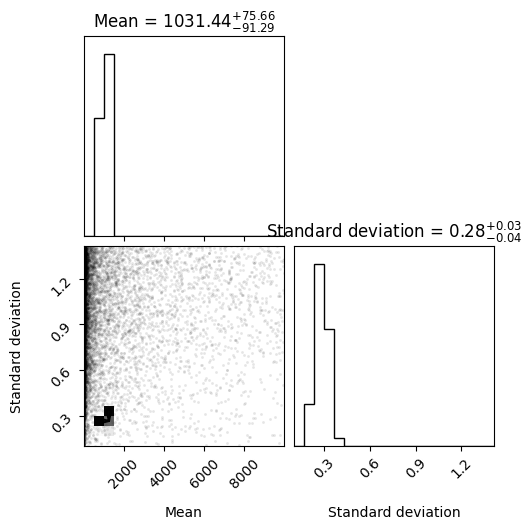

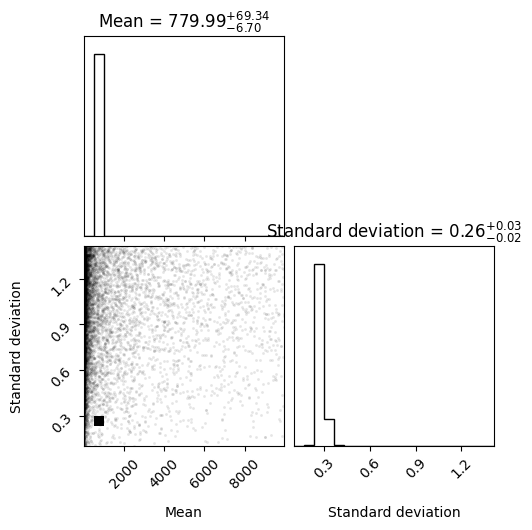

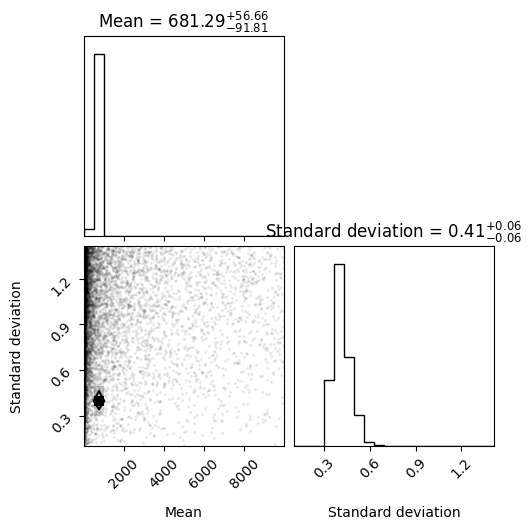

In [5]:
def p_gaussian(bins, mean, variance):

    bins_model = np.arange(np.min(bins), np.max(bins) + 0.05, (bins[1] - bins[0]) / 100)

    model = np.exp(-(bins_model - mean)**2 / (2 * variance))

    p_gaussian = np.zeros(len(bins[:-1]))

    for i, bin in enumerate(bins[:-1]):

        p_gaussian[i] = np.sum(model[(bins_model >= bin) & (bins_model < bins[i + 1])])# * (bins[i + 1] - bin)

    p_gaussian = p_gaussian / (np.sum(p_gaussian) * (bins[1] - bins[0]))

    p_gaussian = norm.cdf(bins[1:], mean, np.sqrt(variance)) - norm.cdf(bins[:-1], mean, np.sqrt(variance))

    return p_gaussian

home = os.getcwd()
results = f'{home}/results'

bins = np.arange(2.5, 3.7, 0.05) 
bins = np.insert(bins, 0, 0)
bins = np.append(bins, 4)
print(bins)

# From Ryan's paper: EW values from 10^2.5 - 10^3.7, in bins of 0.05 dex

names = ['bright', 'faint', 'vfaint']

for name in names:

    with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_{name}.h5', 'r') as f:

        print(len(f.keys()))

for name in names:

    with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_priors_{name}.h5', 'r') as f_prior:

        # Get the EW prior distributions
        ews = f_prior

        with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/endsley2024_f775w_dropouts_beagle_csfh_ews_{name}.h5', 'r') as f:

            # Make empty lists for the probabilities, means, and variances
            probabilities = []
            means = []
            variances = []

            # For each sample
            for n in range(10000):

                # Randomly draw, from a uniform distribution, a mean and variance of an assumed distribution
                mean = np.random.uniform(0, 4)
                variance = np.random.uniform(0.01, 2)

                means.append(mean)
                variances.append(variance)

                # From the sampled mean and variance, create a model Gaussian distribution
                p_model = p_gaussian(bins, mean, variance)

                sums = []

                # For each object
                for key in list(f.keys()):

                    #mask = catalog['ID'] == key

                    # Get the prior distributions of the EWs
                    oiii_ews_prior = ews[key]['oiii_ews'][:]
                    hb_ews_prior = ews[key]['hb_ews'][:]

                    # Get the posterior distributions of the EWs
                    oiii_ews_posterior = f[key]['oiii_ews'][:]
                    hb_ews_posterior = f[key]['hb_ews'][:]

                    # Add the EWs together to get the [O III] + H-beta EW distributions
                    ew_prior = oiii_ews_prior + hb_ews_prior
                    ew_posterior = oiii_ews_posterior + hb_ews_posterior

                    #print(np.median(ew_prior), np.median(ew_posterior))

                    # Create a normalized histogram of the logarithmic EW distributions
                    hist_prior, hist_prior_bins = np.histogram(np.log10(ew_prior), bins=bins, density=True)
                    hist_prior = hist_prior / np.sum(hist_prior)

                    hist_posterior, hist_posterior_bins = np.histogram(np.log10(ew_posterior), bins=bins, density=True)
                    hist_posterior = hist_posterior / np.sum(hist_posterior)

                    '''
                    fig, ax = plt.subplots()

                    print(hist_prior)
                    print(hist_posterior)

                    centers = (bins[:-1] + bins[1:]) / 2

                    #ax.plot(centers, hist_prior, color='black', ds='steps-mid')
                    #ax.plot(centers, hist_posterior, color='red', ds='steps-mid')

                    ax.hist(np.log10(ew_prior), bins, color='black', density=True, alpha=0.5)
                    ax.hist(np.log10(ew_posterior), bins, color='red', density=True, alpha=0.5)

                    plt.show()

                    #print(hist_prior, hist_posterior)
                    '''

                    #p = hist_posterior / (1 / len(hist_prior_bins)) #hist_prior
                    p = hist_posterior / (hist_prior + 1e-10)

                    #print(p)

                    #mask = np.isnan(p) | np.isinf(p) #| (p == 0)

                    p = np.where(np.isnan(p) | np.isinf(p), 1e-10, p)

                    #p = p[~mask]#[~mask]#np.where(np.isnan(p), 0, p)
                    #p = p[~m.isinf(p)]#np.where(np.isinf(p), 0, p)

                    #p_model_n = p_model[~mask]#[~mask]
                    p_model_n = p_model

                    #p = p / np.sum(p)

                    #p = np.where(np.isnan(p), 0, p)

                    sum = 0

                    for j, _ in enumerate(p):

                        sum += p[j] * p_model_n[j]

                    sums.append(sum)

                sums = np.array(sums)
                #print(sums)

                sums = sums[~(np.isnan(sums) | (sums == 0))]

                #print(sums)
                product_log = np.sum(np.log(sums))
                product = np.prod(sums)
                #print(product)

                #print(np.mean(sums))

                #product = 10**(np.sum(np.log10(sums)))

                #print()

                #print(product)

                probabilities.append(product_log)

            with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/ew_distribution_posteriors_{name}.h5', 'a') as f_posteriors:

                '''
                if ids[i] in list(f.keys()):
                    group = f[ids[i]]
                    if 'oiii_ews' in group:
                        del group['oiii_ews']
                    if 'hb_ews' in group:
                        del group['hb_ews']
                    #if 'l_uvs' in group:
                    #    del group['l_uvs']
                    #if 'f200w' in group:
                    #    del group['f200w']
                    #if 'f200w_err' in group:
                    #    del group['f200w_err']
                    if 'probabilities' in group:
                        del group['probabilities']
                    if 'z_phot' in group:
                        del group['z_phot']
                else:
                    group = f.create_group(ids[i])
                '''

                if 'posteriors' in list(f_posteriors.keys()):
                    group = f_posteriors['posteriors']

                    if 'means' in group:
                        del group['means']
                    if 'variances' in group:
                        del group['variances']
                    if 'probabilities' in group:
                        del group['probabilities']

                else:
                    group = f_posteriors.create_group('posteriors')

                #f200w_idx = [k for k, file in enumerate(fit.galaxy.filter_set.filt_dict.keys()) if 'NRC_F200W' in file]
                #print(f200w_idx)
                #print(list(fit.galaxy.filter_set.filt_dict.keys()))#[f200w_idx])


                group.create_dataset('means', data=np.array(means, dtype=np.float64))
                group.create_dataset('variances', data=np.array(variances, dtype=np.float64))
                group.create_dataset('probabilities', data=np.array(probabilities, dtype=np.float64))

                #group = f.create_group(ids[i])
                #dataset = group.create_dataset('hb_ews', data=np.array(hb_ews, dtype=np.float64))
                #dataset = group.create_dataset('oiii_ews', data=np.array(oiii_ews, dtype=np.float64))
                #dataset = group.create_dataset('l_uvs', data=np.array(l_uvs, dtype=np.float64))
                #dataset = group.create_dataset('f200w', data=np.array(galaxy.photometry[:,1][f200w_idx]))#photometry_med.to(u.uJy, u.spectral_density(w_effs)).value[fit.galaxy.filter_set.filt_names.index('NIRCam.F200W')], dtype=np.float64))
                #dataset = group.create_dataset('f200w_err', data=np.array(galaxy.photometry[:,2][f200w_idx]))#(photometry_ul - photometry_ll).to(u.uJy, u.spectral_density(w_effs)).value[fit.galaxy.filter_set.filt_names.index('NIRCam.F200W')], dtype=np.float64))
                #print(z)
                #dataset = group.create_dataset('probabilities', data=np.array(prob, dtype=np.float64))
                #dataset = group.create_dataset('z_phot', data=np.array(z, dtype=np.float64))
                #group.attrs['name'] = ids[i]

                #print(group['means'][:])
                #print(group['variances'][:])
                #print(group['probabilities'][:])
                #print(f_posteriors)

            f_posteriors.close()

            f.close()

        #print(ews)

    results = f'{os.getcwd()}/results'
    with h5py.File(f'./results/endsley2024_f775w_dropouts_beagle_csfh_ews/w335m_mup300/ew_distribution_posteriors_{name}.h5', 'a') as f:

        means = 10**f['posteriors']['means'][:]# + np.log10(7)
        variances = np.sqrt(f['posteriors']['variances'][:])
        probabilities = f['posteriors']['probabilities'][:]

        probabilities = np.exp(probabilities - np.max(probabilities))

        #probabilites = probabilities / np.sum(probabilities)

        samples = np.vstack([means,variances]).T
        print(len(probabilities))
        print(len(probabilities[np.isnan(probabilities)]))
        print(samples)
        print(probabilities)
        corner.corner(samples, weights=probabilities, labels=['Mean', 'Standard deviation'], show_titles=True)

        #corner.corner.savefig(f'{results}/oiii_ew_distribution_log_normal_fit_posteriors.pdf')

In [ ]:
#def plot_sed(sed_observed_file, beagle_results_folder, extras):
def plot_sed():

    home = os.getcwd()
    data = f'{home}/data'
    results = f'{home}/results'

    # Open the file containing the filter throughput curves
    filters = fits.open(f'../BEAGLE-general/filters/jades/filters.fits')

    catalog = fits.open(f'../BEAGLE-general/templates/photometry_z8to10_JADES_Hainline2023.fits')
    #print(obs_phot[1].data)

    ids = catalog[1].data['ID']

    filter_keys = {i: j for i, j in catalog[1].header.items() if i.startswith('TTYPE') and not j == 'ID' and not j=='z_spec' and not j=='z' and not j.endswith('err')}

    w_effs = []

    for i, key in enumerate(filter_keys):

        throughput_curve = filters[1].data[filter_keys[key]][0]

        w_filter = throughput_curve[0] * u.angstrom
        t = throughput_curve[1]

        w_eff = np.trapezoid(w_filter * t) / np.trapezoid(t)

        w_effs.append(w_eff)

    # Get the archived BEAGLE model files
    #objects = glob.glob(f'{beagle_results_folder}/*_BEAGLE.fits.gz')

    objects = [f'{beagle_results_folder}/{id}_BEAGLE.fits.gz' for id in ids]

    # For each modeled object
    for i, object in enumerate(objects):

        #z_spec = z_specs[nircam_id == int(os.path.basename(object).split('_')[0])]
        #print(z_spec, int(os.path.basename(object).split('_')[0]))
        #print(nirspec_id)

        # If the file is not already unzipped
        if not os.path.exists(object[:-3]):
            with gzip.open(object, 'rb') as f:
                with open(object[:-3], 'wb') as out:
                    shutil.copyfileobj(f, out)

        #print(f'{object[:-3]}')
        # Open the BEAGLE model file
        beagle_model = fits.open(f'{object[:-3]}')

        # Get the rest wavelengths of the model SEDs, in Angstroms
        w_rest = Table(beagle_model['FULL SED WL'].data)['wl'].data[0] * u.angstrom

        try:
            # Get the probabilities of the model SEDs
            probabilities = Table(beagle_model['POSTERIOR PDF'].data)['probability'].data
        except KeyError:
            print(f'No posterior PDF found for {ids[i]}')
            continue

        # Get the model SEDs
        model_seds = beagle_model['FULL SED'].data

        '''
        model_sed = []

        for i, bin in enumerate(w):

            f = model_seds[:, i]

            sorted_indices = np.argsort(f)
            data_sorted = f[sorted_indices]
            weights_sorted = probabilities[sorted_indices]

            cumulative_weights = np.cumsum(weights_sorted)

            median_index = np.searchsorted(cumulative_weights, 0.5)

            median_value = data_sorted[median_index]

            model_sed.append(median_value)
        '''

        # Get the highest probability model SED
        model_sed = model_seds[np.argmax(probabilities)] * u.erg / u.s / u.cm**2 / u.angstrom

        # Get the redshift and luminosity distance of the highest probability model SED
        z = Table(beagle_model['GALAXY PROPERTIES'].data)['redshift'].data[np.argmax(probabilities)]
        #luminosity_distance = Table(beagle_model['GALAXY PROPERTIES'].data)['luminosity_distance'].data[np.argmax(probabilities)] * u.Mpc

        # Initialize a figure to plot the object's model SED
        fig, ax = plt.subplots()

        # Create a mask to pick out just a range of rest wavelengths
        mask = (w_rest > 9e2 * u.angstrom) & (w_rest < 1e5 * u.angstrom)

        w_obs = w_rest * (1 + z)
        model_sed = model_sed / (1 + z)

        model_sed = model_sed.to(u.nJy, u.spectral_density(w_obs))

        # Convert the luminosity density to flux density
        #model_sed = model_sed / (4 * np.pi * luminosity_distance**2)

        # Convert the wavelength-space flux density to frequency-space flux density
        #model_sed = model_sed * w**2 / c.to(u.angstrom / u.s)

        # Convert the frequency-space flux density to nanojanskys
        #model_sed = model_sed.to(u.nJy)

        #ax.loglog(w[mask] * (1 + redshift), (model_sed * w**2 / 299792458e10 * 1e23 * 1e9)[mask] / (1 + redshift), label='Model SED', color='black')
        
        # Plot the model SED in observed wavelength space
        #ax.loglog(w_obs[mask], (model_sed)[mask], label='Model SED', color='red', alpha=0.2)

        # Get the index corresponding to the object in the observed photometry
        #idx = np.where(ids == os.path.basename(object).split('_')[0])

        #print(int(os.path.basename(object).split('_')[0]), ids, idx)

        
        #print(filter_keys)

        # For each filter of the observed photometry
        #for j, filter in enumerate(filter_keys):

            #throughput_curve = filters[1].data[filter_keys[filter]][0]

            #w_filter = throughput_curve[0] * u.angstrom
            #t = throughput_curve[1]

            #model_sed_interp = np.interp(w_filter, w_obs[mask], model_sed[mask])

            #model_flux = np.trapezoid(model_sed_interp * t * w_filter, w_filter) / np.trapezoid(t * w_filter, w_filter)

            # Get the flux density and its error
            #flux = catalog[1].data[filter_keys[filter]][idx] * u.nJy
            #flux_err = catalog[1].data[f'{filter_keys[filter]}_err'][idx] * u.nJy

            #print(f'{filter_keys[filter]}: {flux}, {flux_err}')

            # If BEAGLE ignored the filter, skip it
            #if flux.value <= 0 or np.isnan(flux_err.value): #or flux_err < 0:
            #    continue

            #print(filter, flux / flux_err)

            # Plot the observed photometry
            #ax.errorbar(w_effs[j], flux, yerr=flux_err, fmt='o', markerfacecolor='none', markeredgecolor='black', ecolor='black', capsize=3, linestyle='none')

            #ax.errorbar(w_effs[j], model_flux, fmt='s', markerfacecolor='none', markeredgecolor='red', ecolor='red', capsize=3, linestyle='none')

        #ax.set_xlim(9e2 * (1 + z), 1e4 * (1 + z))
        #ax.set_ylim(np.median(model_sed[mask]).value / 5, np.median(model_sed[mask]).value * 5)

        #ax.set_xlabel(r'Observed wavelength (${\AA}$)')

        # BEAGLE docs are unclear about the units of the flux density; they call it a luminosity but then state the units are in erg/s/cm^2/Angstrom
        #ax.set_ylabel('Flux density (nJy)')

        def BEAGLE_median(prob, param):

            s = np.argsort(param)
            cdf = np.cumsum(prob[s])
            cdf /= np.max(cdf)

            interp_param = interp1d(cdf, param[s])
            median = interp_param(0.5)
            interval = interp_param([0.16,0.84])

            return median, interval

        model = beagle_model

        # posterior PDF
        #post = model['posterior pdf']

        # probability function
        prob = probabilities

        # BEAGLE model spectra
        wl = model['full sed wl'].data['wl'][0]
        dwl = np.zeros(len(wl))
        for j in range(len(wl)-2): dwl[j+1] = (wl[j+2]-wl[j])/2.
        sed = model['full sed'].data

        # Calculate emission line EWs

        hb_ews = np.zeros(len(prob))
        oiii_ews = np.zeros(len(prob))

        for n in range(len(prob)):

            f_lam = sed[n,:]
    
            # calculate underlying continuum
            hb_cont_idx = np.where(((wl>=4780.) & (wl<=4840.)) | ((wl>=4880.) & (wl<=4940.)))[0]
            hb_cont = np.median(f_lam[hb_cont_idx])
    
            # calculate H-beta flux
            hb_idx = np.where((wl>=4856.) & (wl<=4866.))[0]
            hb_flux = np.sum(f_lam[hb_idx]*dwl[hb_idx])
    
            # calculate H-beta EW
            hb_ews[n] = hb_flux / hb_cont

            # calculate underlying continuum
            oiii_cont_idx = np.where(((wl>=4880.) & (wl<=4940.)) | ((wl>=5020.) & (wl<=5080.)))[0]
            oiii_cont = np.median(f_lam[oiii_cont_idx])
    
            # calculate H-beta flux
            oiii_idx = np.where((wl>=4954.) & (wl<=5011.))[0]
            oiii_flux = np.sum(f_lam[oiii_idx]*dwl[oiii_idx])
    
            # calculate H-beta EW
            oiii_ews[n] = oiii_flux / oiii_cont

        # calculate posterior median and 1-sigma confidence interval
        hb_ew_median, hb_ew_68 = BEAGLE_median(prob, hb_ews)
        oiii_ew_median, oiii_ew_68 = BEAGLE_median(prob, oiii_ews)
        #print(hb_ew_median, hb_ew_68)

        annotation += '\n' + rf'EW(H$\beta$)$={hb_ew_median:.1f}_{{-{hb_ew_median - hb_ew_68[0]:.1f}}}^{{+{hb_ew_68[1] - hb_ew_median:.1f}}}\,\AA$'
        annotation += '\n' + rf'EW([OIII])$={oiii_ew_median:.1f}_{{-{oiii_ew_median - oiii_ew_68[0]:.1f}}}^{{+{oiii_ew_68[1] - oiii_ew_median:.1f}}}\,\AA$'

        ax.set_title(ids[i], fontweight='bold')

        fig.text(1.02, 0.95, annotation, va='top', ha='left', fontsize=12)

        # Save the figure
        fig.savefig(f'{results}/z8to10_JADES_Hainline2023_2csfh_beagle/{os.path.basename(object[:-8])}_model_sed.pdf', bbox_inches='tight')

        plt.close(fig)

        with h5py.File(f'{results}/beagle_hainline2023_JADES_zgtr8_candidates_2csfh_posteriors.h5', 'a') as f:

            if ids[i] in list(f.keys()):
                group = f[ids[i]]
                if 'oiii_ews' in group:
                    del group['oiii_ews']
                if 'hb_ews' in group:
                    del group['hb_ews']
                #if 'l_uvs' in group:
                #    del group['l_uvs']
                #if 'f200w' in group:
                #    del group['f200w']
                #if 'f200w_err' in group:
                #    del group['f200w_err']
                if 'probabilities' in group:
                    del group['probabilities']
                if 'z_phot' in group:
                    del group['z_phot']
            else:
                group = f.create_group(ids[i])

            #f200w_idx = [k for k, file in enumerate(fit.galaxy.filter_set.filt_dict.keys()) if 'NRC_F200W' in file]
            #print(f200w_idx)
            #print(list(fit.galaxy.filter_set.filt_dict.keys()))#[f200w_idx])


            #group = f.create_group(ids[i])
            dataset = group.create_dataset('hb_ews', data=np.array(hb_ews, dtype=np.float64))
            dataset = group.create_dataset('oiii_ews', data=np.array(oiii_ews, dtype=np.float64))
            #dataset = group.create_dataset('l_uvs', data=np.array(l_uvs, dtype=np.float64))
            #dataset = group.create_dataset('f200w', data=np.array(galaxy.photometry[:,1][f200w_idx]))#photometry_med.to(u.uJy, u.spectral_density(w_effs)).value[fit.galaxy.filter_set.filt_names.index('NIRCam.F200W')], dtype=np.float64))
            #dataset = group.create_dataset('f200w_err', data=np.array(galaxy.photometry[:,2][f200w_idx]))#(photometry_ul - photometry_ll).to(u.uJy, u.spectral_density(w_effs)).value[fit.galaxy.filter_set.filt_names.index('NIRCam.F200W')], dtype=np.float64))
            #print(z)
            dataset = group.create_dataset('probabilities', data=np.array(prob, dtype=np.float64))
            dataset = group.create_dataset('z_phot', data=np.array(z, dtype=np.float64))
            group.attrs['name'] = ids[i]

plot_sed('187', './full/z8to10_JADES_Hainline2023_2csfh_beagle', [''])

TypeError: plot_sed() takes 0 positional arguments but 3 were given